In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! ls

data  MLProject.ipynb  README.md


In [ ]:
%cd drive/MyDrive/Colab Notebooks/MLProject/multi-step-forecasting-rnn

[Errno 2] No such file or directory: 'drive/MyDrive/Colab Notebooks/MLProject/multi-step-forecasting-rnn'
/content/drive/MyDrive/Colab Notebooks/MLProject/multi-step-forecasting-rnn


In [ ]:
!git branch

  main
* ozgur


In [ ]:
!git add .

In [ ]:
import pandas as pd
# loading the dataset
day_ds = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/day.csv')
hour_ds = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/hour.csv')

In [ ]:
hour_ds

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn import preprocessing

# preprocessing the data

# extracting day of week
hour_ds['dteday'] = pd.to_datetime(hour_ds['dteday'])
hour_ds['day of week'] = hour_ds['dteday'].dt.dayofweek

# extracting cyclical features using sine and cosine transformations
cyclical_features = ['season', 'mnth', 'weekday', 'hr']
for feature in cyclical_features:
  hour_ds[f'{feature}_sin'] = np.sin(2 * np.pi * hour_ds[feature] / hour_ds[feature].max())
  hour_ds[f'{feature}_cos'] = np.cos(2 * np.pi * hour_ds[feature] / hour_ds[feature].max())

# creating binary variables for time indicators
hour_ds['afternoon'] = np.where((hour_ds['hr'] >= 12) & (hour_ds['hr'] <= 18), 1, 0)
hour_ds['working hour'] = np.where((hour_ds['hr'] >= 9) & (hour_ds['hr'] <= 17), 1, 0)
hour_ds['holiday'] = np.where(hour_ds['holiday'] == 1, 1, 0)
hour_ds['working day'] = np.where(hour_ds['workingday'] == 1, 1, 0)
hour_ds['month start'] = np.where(hour_ds['dteday'].dt.is_month_start, 1, 0)
hour_ds['quarter start'] = np.where(hour_ds['dteday'].dt.is_quarter_start, 1, 0)

# creating lagged values
target = ['cnt', 'casual', 'registered'] # target variables

# lagged (recent)
for feature in target:
  for i in range(1, 4):
    hour_ds[f'{feature}_lag{i}'] = hour_ds[feature].shift(i)

# lagged (distant)
for feature in target:
  for i in [24, 48, 168]:
    hour_ds[f'{feature}_lag{i}'] = hour_ds[feature].shift(i)

print(hour_ds.shape)
hour_df = hour_ds.dropna()
print(hour_df.shape)

(17379, 49)
(17211, 49)


In [ ]:
hour_df

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,...,registered_lag3,cnt_lag24,cnt_lag48,cnt_lag168,casual_lag24,casual_lag48,casual_lag168,registered_lag24,registered_lag48,registered_lag168
168,169,2011-01-08,1,0,1,7,0,6,0,2,...,1.0,84.0,36.0,16.0,8.0,0.0,3.0,76.0,36.0,13.0
169,170,2011-01-08,1,0,1,8,0,6,0,3,...,5.0,210.0,95.0,40.0,20.0,0.0,8.0,190.0,95.0,32.0
170,171,2011-01-08,1,0,1,9,0,6,0,3,...,2.0,134.0,219.0,32.0,9.0,3.0,5.0,125.0,216.0,27.0
171,172,2011-01-08,1,0,1,10,0,6,0,2,...,8.0,63.0,122.0,13.0,16.0,6.0,3.0,47.0,116.0,10.0
172,173,2011-01-08,1,0,1,11,0,6,0,2,...,15.0,67.0,45.0,1.0,19.0,3.0,0.0,48.0,42.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,...,184.0,102.0,97.0,26.0,16.0,7.0,6.0,86.0,90.0,20.0
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,...,150.0,72.0,66.0,18.0,9.0,2.0,4.0,63.0,64.0,14.0
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,...,112.0,47.0,60.0,23.0,5.0,4.0,6.0,42.0,56.0,17.0
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,...,108.0,36.0,54.0,22.0,6.0,3.0,13.0,30.0,51.0,9.0


In [ ]:
# scaling
scaler = preprocessing.MinMaxScaler()
scaled_features = [
    'season_sin',
    'season_cos',
    'mnth_sin',
    'mnth_cos',
    'weekday_sin',
    'weekday_cos',
    'hr_sin',
    'hr_cos',
    'cnt',
    'casual',
    'registered',
    'cnt_lag1',
    'cnt_lag2',
    'cnt_lag3',
    'cnt_lag24',
    'cnt_lag48',
    'cnt_lag168'
]

# Store the original index
original_index = hour_df.index

scaled_df = pd.DataFrame(scaler.fit_transform(hour_df[scaled_features]), columns=scaled_features)

# Reset the index of scaled_df to match the original DataFrame
scaled_df.index = original_index

# Drop the original features using .loc or .iloc
hour_df = hour_df.loc[:, ~hour_df.columns.isin(scaled_features)]

hour_df = pd.concat([hour_df, scaled_df], axis=1)

# selecting relevant features
final_cols = [
    'season_sin',
    'season_cos',
    'day of week',
    'mnth_sin',
    'mnth_cos',
    'weekday_sin',
    'weekday_cos',
    'hr_sin',
    'hr_cos',
    'holiday',
    'afternoon',
    'working hour',
    'working day',
    'month start',
    'quarter start',
    'cnt_lag1',
    'cnt_lag2',
    'cnt_lag3',
    'cnt_lag24',
    'cnt_lag48',
    'cnt_lag168'
]

target = 'cnt'

hour_df_final = hour_df[final_cols + [target]]

print(hour_df_final.shape)
hour_final = hour_df_final.dropna()
print(hour_final.shape)

(17211, 22)
(17211, 22)


In [ ]:
hour_final

,season_sin,season_cos,day of week,mnth_sin,mnth_cos,weekday_sin,weekday_cos,hr_sin,hr_cos,holiday,...,working day,month start,quarter start,cnt_lag1,cnt_lag2,cnt_lag3,cnt_lag24,cnt_lag48,cnt_lag168,cnt
168,1.0,0.5,5,0.75,0.933013,0.5,1.00,0.972231,3.294374e-01,0,...,0,0,0,0.001025,0.004098,0.000000,0.085041,0.035861,0.015369,0.008197
169,1.0,0.5,5,0.75,0.933013,0.5,1.00,0.909439,2.079713e-01,0,...,0,0,0,0.008197,0.001025,0.004098,0.214139,0.096311,0.039959,0.014344
170,1.0,0.5,5,0.75,0.933013,0.5,1.00,0.816281,1.079902e-01,0,...,0,0,0,0.014344,0.008197,0.001025,0.136270,0.223361,0.031762,0.019467
171,1.0,0.5,5,0.75,0.933013,0.5,1.00,0.699666,3.690921e-02,0,...,0,0,0,0.019467,0.014344,0.008197,0.063525,0.123975,0.012295,0.061475
172,1.0,0.5,5,0.75,0.933013,0.5,1.00,0.568242,5.551115e-17,0,...,0,0,0,0.061475,0.019467,0.014344,0.067623,0.045082,0.000000,0.062500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,1.0,0.5,0,0.50,1.000000,1.0,0.75,0.055020,7.287694e-01,0,...,1,0,0,0.123975,0.167008,0.218238,0.103484,0.098361,0.025615,0.120902
17375,1.0,0.5,0,0.50,1.000000,1.0,0.75,0.133728,8.405339e-01,0,...,1,0,0,0.120902,0.123975,0.167008,0.072746,0.066598,0.017418,0.090164
17376,1.0,0.5,0,0.50,1.000000,1.0,0.75,0.239601,9.268691e-01,0,...,1,0,0,0.090164,0.120902,0.123975,0.047131,0.060451,0.022541,0.091189
17377,1.0,0.5,0,0.50,1.000000,1.0,0.75,0.364786,9.813719e-01,0,...,1,0,0,0.091189,0.090164,0.120902,0.035861,0.054303,0.021516,0.061475


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
# references: https://carpentries-incubator.github.io/machine-learning-novice-python/07-bootstrapping/index.html

# splitting the data into train and test (70% and 30%)
split_point = int(len(hour_final) * 0.7)
train_set, future_test_set = train_test_split(hour_final, test_size=0.3, shuffle=False)
X_test = future_test_set[final_cols]
y_test = future_test_set[target]

# storing training and validation sets during bootstrapping
train_sets = []
val_sets = []

# bootstrap sampling
bootstrap_samples = 50
for _ in range(bootstrap_samples):
    train_bs = resample(train_set, replace=True)
    X_train = train_bs[final_cols]
    y_train = train_bs[target]

    val_bs = train_set.loc[~train_set.index.isin(train_bs.index)]
    X_val = val_bs[final_cols]
    y_val = val_bs[target]

    train_sets.append((train_bs[final_cols], train_bs[target]))
    val_sets.append((val_bs[final_cols], val_bs[target]))

In [ ]:

print(X_train.shape)

(12047, 21)


In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
# references:
# https://towardsdatascience.com/multivariate-timeseries-forecast-with-lead-and-lag-timesteps-using-lstm-1a34915f08a
# https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

# reshape train
X_train_array = X_train.values
X_train_reshaped = X_train_array.reshape((X_train_array.shape[0], 1, X_train_array.shape[1]))

# reshape validation
X_val_array = X_val.values
X_val_reshaped = X_val_array.reshape((X_val_array.shape[0], 1, X_val_array.shape[1]))

# building the baseline LSTM model
base_model = Sequential()
base_model.add(LSTM(units=50, input_shape=(1, X_train.shape[1]), dropout=0.5))
# adding a dense layer of a single unit
base_model.add(Dense(units=1))
# using MSE loss function minimized using Adam optimizer
base_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# training
base_model.fit(X_train_reshaped, y_train, epochs=128, batch_size=128, validation_data=(X_val_reshaped, y_val), shuffle=True)



Epoch 1/128
95/95 [==============================] - 7s 23ms/step - loss: 0.0201 - val_loss: 0.0089
Epoch 2/128
95/95 [==============================] - 1s 11ms/step - loss: 0.0122 - val_loss: 0.0072
Epoch 3/128
95/95 [==============================] - 1s 9ms/step - loss: 0.0118 - val_loss: 0.0074
Epoch 4/128
95/95 [==============================] - 1s 12ms/step - loss: 0.0116 - val_loss: 0.0075
Epoch 5/128
95/95 [==============================] - 1s 13ms/step - loss: 0.0111 - val_loss: 0.0072
Epoch 6/128
95/95 [==============================] - 1s 14ms/step - loss: 0.0109 - val_loss: 0.0071
Epoch 7/128
95/95 [==============================] - 2s 17ms/step - loss: 0.0110 - val_loss: 0.0068
Epoch 8/128
95/95 [==============================] - 1s 15ms/step - loss: 0.0110 - val_loss: 0.0074
Epoch 9/128
95/95 [==============================] - 1s 12ms/step - loss: 0.0109 - val_loss: 0.0074
Epoch 10/128
95/95 [==============================] - 1s 10ms/step - loss: 0.0104 - val_loss: 0.0073


In [ ]:
#Reshape Validation
X_test_array = X_test.values
X_test_reshaped = X_test_array.reshape((X_test_array.shape[0], 1, X_test_array.shape[1]))

# evaluation
loss = base_model.evaluate(X_test_reshaped, y_test)
print(f'Model Loss on Test Set: {loss}')

162/162 [==============================] - 0s 2ms/step - loss: 0.0301
Model Loss on Test Set: 0.03011983260512352


In [ ]:
# generating one-step predictions for first 100 steps of test set forecasts
def onestep_forecasts(model, X):
  forecasts = []
  for i in range(len(X)):
    forecast_step = model.predict(X[i].reshape(1, X.shape[1], X.shape[2]))
    forecasts.append(forecast_step[0, 0])

  return np.array(forecasts)

one_step_forecasts = onestep_forecasts(base_model, X_test_reshaped[:100])

In [ ]:
one_step_forecasts

array([0.11116014, 0.11943672, 0.14299232, 0.19590902, 0.2946769 ,
       0.23051164, 0.0883605 , 0.11690941, 0.13226618, 0.15044816,
       0.14056225, 0.15221411, 0.18567011, 0.31460208, 0.44797695,
       0.34276855, 0.2544583 , 0.17107117, 0.1626164 , 0.12354498,
       0.10949324, 0.10784421, 0.1064041 , 0.10118614, 0.10919061,
       0.12257265, 0.15506637, 0.2583725 , 0.38006037, 0.22462113,
       0.07034129, 0.08107921, 0.10377519, 0.12006924, 0.13627368,
       0.13989034, 0.17423356, 0.31252545, 0.46193475, 0.38964373,
       0.25880235, 0.2217792 , 0.18221615, 0.159557  , 0.14422408,
       0.12929851, 0.11172628, 0.10616095, 0.112468  , 0.12876955,
       0.16884738, 0.26198798, 0.4049191 , 0.23638962, 0.06496876,
       0.07422312, 0.10683829, 0.13437697, 0.13665864, 0.14371815,
       0.18981262, 0.41142917, 0.5059684 , 0.4015671 , 0.2974493 ,
       0.23813505, 0.18817991, 0.16133587, 0.15140708, 0.13386515,
       0.12257268, 0.11678718, 0.1193439 , 0.13476728, 0.17500

In [ ]:
# generating multi-step forecasts for the first 100 steps of test set forecasts
def multistep_forecasts(model, X, n_steps):
    forecasts = []
    current_input = X[0].reshape(1, X.shape[1], X.shape[2])

    for _ in range(n_steps):
        # Predict the next time step
        forecast_step = model.predict(current_input)
        forecasts.append(forecast_step[0, 0])

        # Update the input for the next time step
        current_input = np.roll(current_input, shift=-1, axis=1)
        current_input[0, -1, 0] = forecast_step[0, 0]

    return np.array(forecasts)

n_steps = 100  # using 16-step unrolled sequences
multi_step_forecasts = multistep_forecasts(base_model, X_test_reshaped[:100], n_steps)

1/1 [==============================] - 0s 24ms/step


In [ ]:
print(multi_step_forecasts)

[0.11116014 0.1086544  0.10863205 0.10863187 0.10863187 0.10863187
 0.10863187 0.10863187 0.10863187 0.10863187 0.10863187 0.10863187
 0.10863187 0.10863187 0.10863187 0.10863187 0.10863187 0.10863187
 0.10863187 0.10863187 0.10863187 0.10863187 0.10863187 0.10863187
 0.10863187 0.10863187 0.10863187 0.10863187 0.10863187 0.10863187
 0.10863187 0.10863187 0.10863187 0.10863187 0.10863187 0.10863187
 0.10863187 0.10863187 0.10863187 0.10863187 0.10863187 0.10863187
 0.10863187 0.10863187 0.10863187 0.10863187 0.10863187 0.10863187
 0.10863187 0.10863187 0.10863187 0.10863187 0.10863187 0.10863187
 0.10863187 0.10863187 0.10863187 0.10863187 0.10863187 0.10863187
 0.10863187 0.10863187 0.10863187 0.10863187 0.10863187 0.10863187
 0.10863187 0.10863187 0.10863187 0.10863187 0.10863187 0.10863187
 0.10863187 0.10863187 0.10863187 0.10863187 0.10863187 0.10863187
 0.10863187 0.10863187 0.10863187 0.10863187 0.10863187 0.10863187
 0.10863187 0.10863187 0.10863187 0.10863187 0.10863187 0.1086

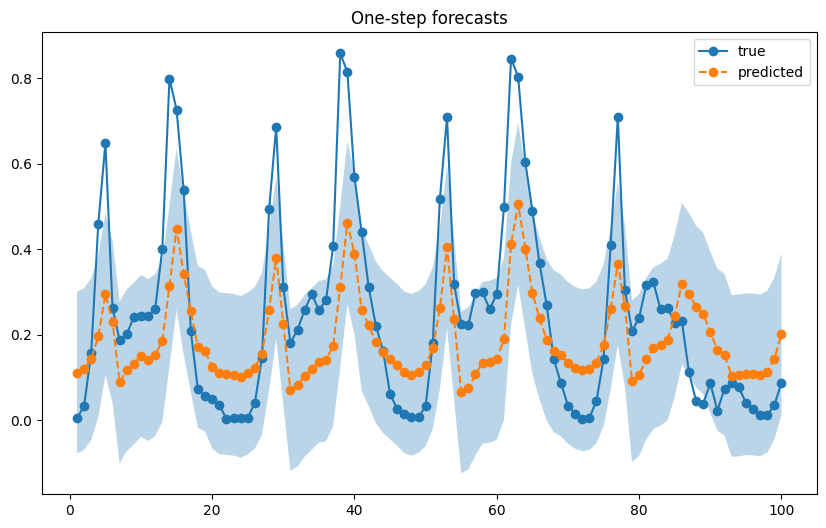

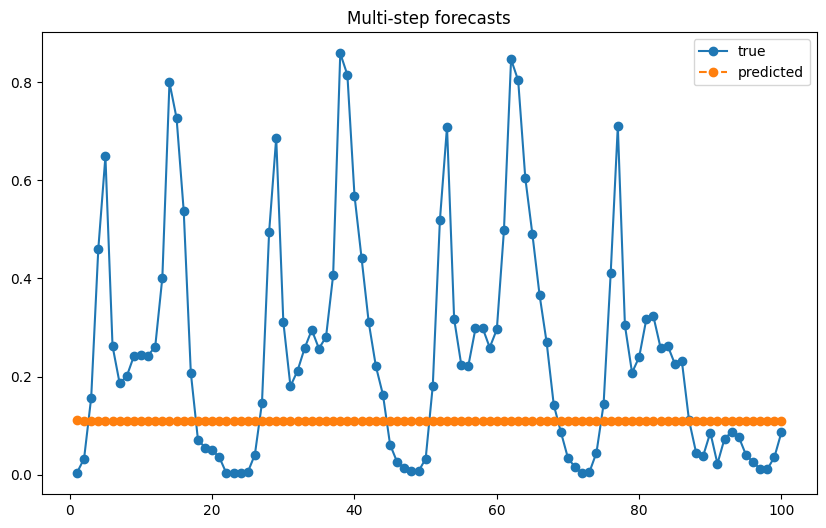

In [ ]:
import matplotlib.pyplot as plt

# plotting true and predicted lines for each set of forecasts

# one-step
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, 101), y_test[:100], label='true', marker='o', linestyle='-')
plt.plot(np.arange(1, 101), one_step_forecasts, label='predicted', marker='o', linestyle='--')
# calculating upper and lower bounds for prediction intervals
plt.fill_between(np.arange(1, 101),
                 one_step_forecasts - 1.96 * np.std(one_step_forecasts),
                 one_step_forecasts + 1.96 * np.std(one_step_forecasts),
                 alpha=0.3)
plt.title('One-step forecasts')
plt.legend()
plt.show()

# multi-step
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, 101), y_test[:100], label='true', marker='o', linestyle='-')
plt.plot(np.arange(1, 101), multi_step_forecasts, label='predicted', marker='o', linestyle='--')
plt.fill_between(np.arange(1, 101),
                 multi_step_forecasts - 1.96 * np.std(multi_step_forecasts),
                 multi_step_forecasts + 1.96 * np.std(multi_step_forecasts),
                 alpha=0.3)
plt.title('Multi-step forecasts')
plt.legend()
plt.show()